In [1]:
import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [2]:
data_1 = pd.read_csv("regulardataset.csv")
data_2 = pd.read_csv("sar1.csv")
data =  pd.concat([data_1, data_2])
data.head()

,date_time,tweet,splchar1,splchar2,is_sarcastic
0,27-03-2021 14:07,b'Excited to share the latest addition to my #...,b'RF_Vintage',"b'North Carolina, USA'",0
1,27-03-2021 14:06,b'Excited to share the latest addition to my #...,b'RF_Vintage',"b'North Carolina, USA'",0
2,27-03-2021 12:30,b'With a #Systematic #Investment #Plan (#SIP) ...,b'sisbl_in',b'Kolkata',0
3,27-03-2021 09:29,b'Regular expressions - I have just completed ...,b'careydcooper5',b'Isle of Man',0
4,27-03-2021 08:05,b'Well she said yes. I have a problem as it is...,b'dustwax',b'',0


# New Section

In [3]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [5]:
print(data)

             date_time  ... is_sarcastic
0     27-03-2021 14:07  ...            0
1     27-03-2021 14:06  ...            0
2     27-03-2021 12:30  ...            0
3     27-03-2021 09:29  ...            0
4     27-03-2021 08:05  ...            0
...                ...  ...          ...
1572  19-03-2021 17:43  ...            1
1573  19-03-2021 17:42  ...            1
1574  19-03-2021 17:39  ...            1
1575  19-03-2021 17:33  ...            1
1576  19-03-2021 17:28  ...            1

[1616 rows x 5 columns]


In [6]:
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    tweets = list()
    lines = df["tweet"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        tweets.append(words)
    return tweets

tweets = CleanTokenize(data)
tweets[0:10]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[['bexcited',
  'share',
  'latest',
  'addition',
  'etsy',
  'shop',
  'pearl',
  'snap',
  'button',
  'shirt',
  'gap',
  'cowboy',
  'shirt'],
 ['bexcited',
  'share',
  'latest',
  'addition',
  'etsy',
  'shop',
  'vintage',
  'jeans',
  'wrangler',
  'jeans',
  'high',
  'waist',
  'jeans'],
 ['bwith',
  'systematic',
  'investment',
  'plan',
  'sip',
  'need',
  'worry',
  'timing',
  'market',
  'make'],
 ['b',
  'aregular',
  'expressions',
  'completed',
  'room',
  'check',
  'tryhackme',
  'regular'],
 ['bwell', 'said', 'yes', 'problem', 'regularni', 'spoke', 'told', 'worry'],
 ['wait', 'get', 'top', 'bentley', 'regular'],
 ['bnew',
  'png',
  'today',
  'triangle',
  'square',
  'angle',
  'red',
  'square',
  'regular',
  'polygon',
  'point',
  'visit',
  'site'],
 ['blove',
  'regular',
  'table',
  'localcoffeeshop',
  'available',
  'looking',
  'forward',
  'settling',
  'making'],
 ['bbreaking',
  'news',
  'preordering',
  'receive',
  'bottle',
  'bbq',
  'sauc

(-0.5, 999.5, 499.5, -0.5)

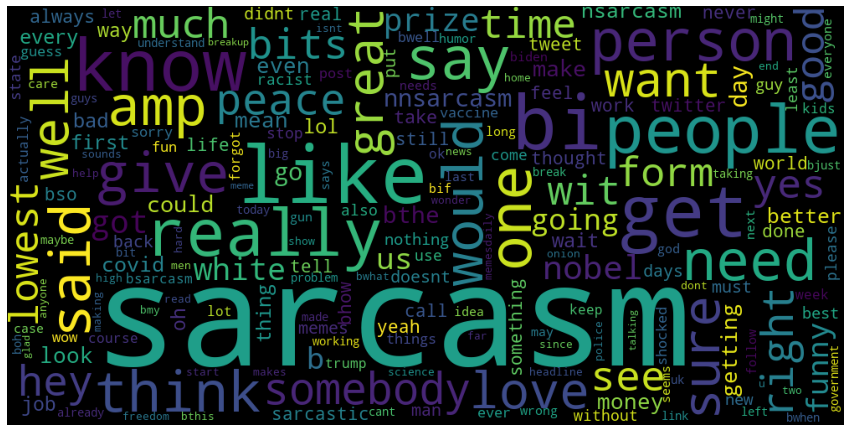

In [7]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = data.loc[data['is_sarcastic'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

In [8]:
validation_split = 0.2
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(tweets)
sequences = tokenizer_obj.texts_to_sequences(tweets)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['is_sarcastic'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  5886
vocab size - 5887


In [9]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (1293, 25)
Shape of y_train: (1293,)
Shape of X_test_pad: (323, 25)
Shape of y_test: (323,)


In [10]:
embeddings_index = {}
embedding_dim = 100
f = open(os.path.join('','glove.twitter.27B.100d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 9817 word vectors.


In [11]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

2017


In [13]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [14]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 100)           588700    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 631,005
Trainable params: 42,305
Non-trainable params: 588,700
_________________________________________________________________
None


In [15]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/25
41/41 - 5s - loss: 0.2569 - acc: 0.9753 - val_loss: 0.1062 - val_acc: 0.9783
Epoch 2/25
41/41 - 1s - loss: 0.1173 - acc: 0.9753 - val_loss: 0.1049 - val_acc: 0.9783
Epoch 3/25
41/41 - 1s - loss: 0.1168 - acc: 0.9753 - val_loss: 0.1049 - val_acc: 0.9783
Epoch 4/25
41/41 - 1s - loss: 0.1169 - acc: 0.9753 - val_loss: 0.1046 - val_acc: 0.9783
Epoch 5/25
41/41 - 1s - loss: 0.1039 - acc: 0.9783 - val_loss: 0.0822 - val_acc: 0.9845
Epoch 6/25
41/41 - 1s - loss: 0.0955 - acc: 0.9675 - val_loss: 0.0952 - val_acc: 0.9690
Epoch 7/25
41/41 - 1s - loss: 0.0746 - acc: 0.9799 - val_loss: 0.0812 - val_acc: 0.9814
Epoch 8/25
41/41 - 1s - loss: 0.0696 - acc: 0.9838 - val_loss: 0.0769 - val_acc: 0.9814
Epoch 9/25
41/41 - 1s - loss: 0.0675 - acc: 0.9869 - val_loss: 0.0765 - val_acc: 0.9814
Epoch 10/25
41/41 - 1s - loss: 0.0588 - acc: 0.9884 - val_loss: 0.0718 - val_acc: 0.9845
Epoch 11/25
41/41 - 1s - loss: 0.0585 - acc: 0.9884 - val_loss: 0.0729 - val_acc: 0.9845
Epoch 12/25
41/41 - 1s - loss:

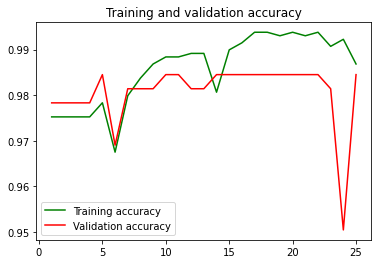

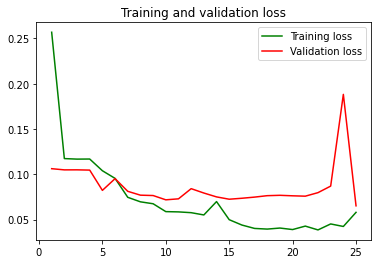

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.manifold import TSNE

In [18]:
model_glove = Sequential()
model_glove.add(Embedding(vocab_size , 100, input_length=50, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print('Summary of the built model...')
print(model_glove.summary())

Summary of the built model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           588700    
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 686,865
Trainable params: 98,165
Non-trainable params: 588,700
_____________

In [25]:
history = model_glove.fit(X_train_pad, y_train, batch_size=32, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/25
41/41 - 1s - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.1129 - val_accuracy: 0.9845
Epoch 2/25
41/41 - 1s - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.1111 - val_accuracy: 0.9845
Epoch 3/25
41/41 - 1s - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.1153 - val_accuracy: 0.9845
Epoch 4/25
41/41 - 1s - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.1186 - val_accuracy: 0.9845
Epoch 5/25
41/41 - 1s - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.1132 - val_accuracy: 0.9845
Epoch 6/25
41/41 - 1s - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.1212 - val_accuracy: 0.9845
Epoch 7/25
41/41 - 1s - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.1145 - val_accuracy: 0.9845
Epoch 8/25
41/41 - 1s - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.1189 - val_accuracy: 0.9845
Epoch 9/25
41/41 - 1s - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.1195 - val_accuracy: 0.9845
Epoch 10/25
41/41 - 1s - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.1204 - val_accuracy: 0.9845
Epoch 11/25
41/41 -

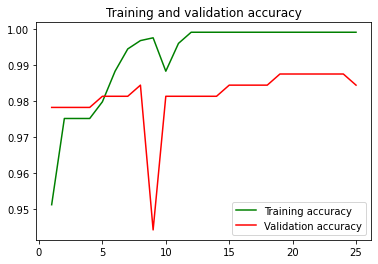

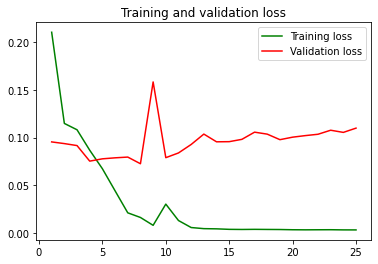

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"tweet":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's a sarcasm!" 
    else: return "It's not a sarcasm."

In [23]:
predict_sarcasm("I was depressed. He asked me to be happy. I am not depressed anymore.")

"It's a sarcasm!"

In [24]:
predict_sarcasm("New PNG Today - Triangle Square Angle Red #square #regular polygon #point  https://t.co/41lvfujHiv Visit our site! https://t.co/hcsPjQHT0O")

"It's not a sarcasm."